# Lab 3

## #1 Data Retrieval
We get all the data necessary from the Materials Project using the provided material-ids

In [1]:
from mp_api.client import MPRester
from pymatgen.core import Element, Structure, Composition, Lattice
import pandas as pd
import numpy as np

train_data_raw = pd.read_csv('data/train_oxides.csv')
train_data_raw.set_index('material_id', inplace=True)
Y_train = train_data_raw[['formation_energy_per_atom']]

In [3]:
# Acquire Material Project API with MPRester for required fields
with MPRester("vTVq5BnCcZkrMtsqdQG24AEZJIIxnXa9") as mpr:
    docs = mpr.materials.summary.search(
        material_ids=list(train_data_raw.index)
    )

Retrieving SummaryDoc documents:   0%|          | 0/71913 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/mp_api/client/core/client.py:664: UserWarning: Use the 'fields' argument to select only fields of interest to speed up data retrieval for large queries. Choose from: ['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_form

In [4]:
# Make it into Pandas data frame
raw_data_tmp = []
for doc in docs:
    doc_data = {}
    for feature, value in doc:
        doc_data[feature] = value
    raw_data_tmp.append(doc_data)
# Convert the list of dictionaries into a DataFrame
raw_data_df = pd.DataFrame(raw_data_tmp)
# Saved to local for easier access later; File naem = "train_data_pandas.pkl"

## #2 Data Featurizing
We will divide the input data into two different sections, and concatenate later on to make a singular input data:
1. Compositional Data(avg, min, max): For this, we will first use all of the elemental data that is provided in the Element object to compute the avg, min, and max of each of the compound. Then, we will use PCA to only use the most impactful ones. However, since a lot of data will be derived from structural data, the eigenvalue cut-off might be higher than 1, depending on the end structure of the input data
2. Structural Data: Data from Material Project about the compound structure will be featurized using featurizer from matminer

### #2.1 Compositional Data

#### #2.1.1 Elemental Data
First create a dataframe which will hold all the elemental data, so that average, maximum, and minimum property calculation is efficient. I selected all the numerical property values that the Element object held in its implementation.

In [5]:
# Create a element data df so that missing values can be accounted for and access is efficient
# Almost all of the numerically expressed element data that is present in Pymatgen is used, since 
# PCA will be later performed to get rid of unnecssary factors
element_data = []
for element in Element:
    element_info = {
        "symbol": element.symbol,
        "atomic_number": element.Z,
        "atomic_radius_calculated": element.atomic_radius_calculated,
        "van_der_waals_radius": element.van_der_waals_radius,
        "mendeleev_no": element.mendeleev_no,
        "electrical_resistivity": element.electrical_resistivity,
        "poissons_ratio": element.poissons_ratio,
        "molar_volume": element.molar_volume,
        "thermal_conductivity": element.thermal_conductivity,
        "boiling_point": element.boiling_point,
        "melting_point": element.melting_point,
        "critical_temperature": element.critical_temperature,
        "bulk_modulus": element.bulk_modulus,
        "youngs_modulus": element.youngs_modulus,
        "brinell_hardness":element.brinell_hardness,
        "rigidity_modulus": element.rigidity_modulus,
        "density_of_solid": element.density_of_solid,
        "coefficient_of_linear_thermal_expansion": element.coefficient_of_linear_thermal_expansion,
        "1st_ionization_energy": None,
        "2nd_ionization_energy": None,
    }
    if len(element.ionization_energies) >= 2:
        element_info["1st_ionization_energy"] = element.ionization_energies[0]
        element_info["2nd_ionization_energy"] = element.ionization_energies[1]
    elif len(element.ionization_energies) == 1:
        element_info["1st_ionization_energy"] = element.ionization_energies[0]
    element_data.append(element_info)
# element_df now has all elemental data for all of the elements in the periodic table
element_df = pd.DataFrame(element_data)
# Since not all elemental data is needed, we will only keep the elements that are used in our training set and test set.
# Initialize to store unique elements
unique_elements = set()
# Get test set
test_data_raw = pd.read_csv('data/test_oxides.csv')
# Find all the elements that are used in our test set 
chemical_formulas = test_data_raw['formula_pretty']
# Iterate over each formula
for formula in chemical_formulas:
    composition = Composition(formula)
    for element in composition.elements:
        unique_elements.add(element.symbol)
# Find all the elements that are used in our training set 
for elements in raw_data_df['elements']:
    for element in elements:
        unique_elements.add(element.symbol)
all_elements = set(element_df["symbol"])
# Remove all the elements that are not included in the training set
element_df = element_df[~element_df['symbol'].isin(all_elements - unique_elements)]
# Make the symbol index of the element dataframe
element_df.set_index('symbol', inplace=True)
# Fill in Na cells with average
element_df.fillna(element_df.mean(),inplace=True)
# Saved to local for easier access later; File name = "element_data.csv"
element_df.to_csv('element_data.csv')

/opt/homebrew/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for electrical_resistivity for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/opt/homebrew/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for poissons_ratio for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/opt/homebrew/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for bulk_modulus for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/opt/homebrew/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for youngs_modulus for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/opt/homebrew/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:186: UserWarning: No data available for brinell_hardness for H
  warnings.warn(f"No data available for {ite

#### #2.1.2 Calculation of Average, Minimum, and Maximum Elemental Proeprty of Each Compound
With elemental datas in place, now we can go ahead and compute the average, min, and max of each of the properties of each compound.

In [6]:
# Define a set of helper functions to get the max, min, and average property values.
def max_comp(comp):
    maxi = -float('inf')
    for element, _ in comp.items():
        # Look up the property of interest from the elemental information
        atomic_property = element_dict[element.symbol]
        if atomic_property:
            maxi = max(maxi, atomic_property)
    return maxi

def min_comp(comp):
    mini = float('inf')
    for element, _ in comp.items():
        # Look up the property of interest from the elemental information
        atomic_property = element_dict[element.symbol]
        if atomic_property:
            mini = min(mini, atomic_property)
    return mini

def avg_comp(comp):
    total_property = 0
    total_amount = 0
    for element, amount in comp.items():
        # Look up the property of interest from the elemental information
        atomic_property = element_dict[element.symbol]
        if atomic_property:
            total_property += atomic_property * amount
            total_amount += amount
    return total_property / total_amount if total_amount else None

# Declare variables for use in the for loop
prop_df = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()] # indx 0 : max_properties; indx 1 : min_properties ; indx 2 : avg_properties
composition_operators = [max_comp, min_comp, avg_comp]
name = ['_max', '_min', '_avg']
# Set index of the training data for easier visualization
raw_data_df.set_index('material_id', inplace=True)
# Get max, min, and avg of compositional properties of each compound
for i in range(3):
    for property in element_df.columns:
        # Make dictionary for faster access to the property of interest
        element_dict = element_df[property].to_dict()
        # Calculate the composition-averaged property for all materials
        result = raw_data_df['composition'].apply(composition_operators[i])
        prop_df[i].loc[:, property + name[i]]  = result

max_properties = prop_df[0]
min_properties = prop_df[1]
avg_properties = prop_df[2]

In [7]:
# Here is a visualization of each of the max, min, avg dataframes
print(f'avg_properties : dimension {avg_properties.shape}\n', '_'*30,'\n', avg_properties.head(2),'\n\n', '._'*30)
print(f'max_properties : dimension {max_properties.shape}\n', '_'*30,'\n', max_properties.head(2),'\n\n', '._'*30)
print(f'\nmin_properties : dimension {min_properties.shape}\n', '_'*30,'\n', min_properties.head(2))

avg_properties : dimension (71913, 19)
 ______________________________ 
              atomic_number_avg  atomic_radius_calculated_avg  \
material_id                                                    
mp-27404             10.222222                      0.603889   
mp-1260244           16.545455                      0.783636   

             van_der_waals_radius_avg  mendeleev_no_avg  \
material_id                                               
mp-27404                     1.458333         99.555556   
mp-1260244                   1.696364         93.909091   

             electrical_resistivity_avg  poissons_ratio_avg  molar_volume_avg  \
material_id                                                                     
mp-27404                   1.054863e+21            0.292444         14.975000   
mp-1260244                 8.055317e+20            0.315192         15.827273   

             thermal_conductivity_avg  boiling_point_avg  melting_point_avg  \
material_id                  

In [8]:
# By combining the three matrix, create the design matrix
composition_design_matrix = pd.concat([avg_properties, max_properties, min_properties], axis=1)
print(f'Compositional Design Matrix Dimension: {composition_design_matrix.shape}')

Compositional Design Matrix Dimension: (71913, 57)


#### #2.1.3 Dimensional Reduction of Composition Input Data
However, we can see that there are already 57 total inputs from just the compositional data. This might be too much, especially with the limitations of local computers when considering reasonable training time and efficiency. Since we will later also have more inputs from structural features, I decided that it would be wise to prune some less important factors using Principle Component Analysis(PCA) by reducing the dimension of the *composition_design_matrix*.


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(composition_design_matrix)
# Applying PCA
pca = PCA()
pca.fit(df_scaled)
# Get the Eigenvalues
eigenvalues = pca.explained_variance_
# Filter components with eigenvalue > 1
num_components_PCA_composition = sum(eigenvalue > 1 for eigenvalue in eigenvalues)
# Refit PCA with filtered components
pca_filtered = PCA(n_components=num_components_PCA_composition)
composition_design_matrix_pca = pca_filtered.fit_transform(df_scaled)
# Massage the data into pd.DataFrame with appropriate index
composition_design_matrix_pca = pd.DataFrame(composition_design_matrix_pca)
composition_design_matrix_pca.index = composition_design_matrix.index
composition_design_matrix_pca.columns = [f'Composition_Property_Feature_PCA_{n}' for n in range(13)]
# Results
print(f"Number of components with eigenvalue > 1: {num_components_PCA_composition}")
print(f"Final Compositional Design Matrix Dimension: {composition_design_matrix_pca.shape}")

Number of components with eigenvalue > 1: 13
Final Compositional Design Matrix Dimension: (71913, 13)


### #2.2 Structural Data
#### #2.2.1 Featurization of Structural Data using matminer
In this part of the lab, sturctural information of the compounds will be used with featurizers. We will be using structural featurizers that are found in matminer. After reading through the documentation, the following featurizers were decided to be used:
- **StructuralHeterogeneity**: This featurizer measures the variability in bond lengths and atomic volumes of the material. Such variabilities impacts the stability and energy of a compound, which are critical factors in formation energy. Structures with high heterogeneity might imply higher energy states, potentially leading to higher formation energies.

- **ChemicalOrdering**: This assesses the degree of ordering in the arrangement of elements. Highly ordered structures tend to have lower formation energies due to their stable configurations. Thus, I believed that the feature can be a key predictor in identifying compounds with lower or higher formation energies.

- **MaximumPackingEfficiency**: This calculates the density of atomic packing. Densely packed structures generally indicate strong interatomic interactions, which are likely to contribute to lower formation energies due to the stability.

- **GlobalSymmetryFeatures**: This evaluates the symmetry of the crystal structure. Symmetrical structures often have lower energy states, which is why I believed this feature is a crucial aspect in predicting the formation energy. 

- **DensityFeatures**: This embeds material density, a fundamental property influencing formation energy. Higher density often correlates with lower formation energy due to the efficient packing and strong bonding of atoms.

- **SiteStatsFingerprint.CoordinationNumber**: This calculates the effective coordination number (CN_eff) for each atom in a structure. Since the coordination number reflects the geometric arrangement and density of packing around an atom, I believed that the compound's stability and energy-and in turn the formation energy-will be closely related.

- **SiteStatsFingerprint.LocalPropertyDifference**: This evaluates the local environment of each atom by comparing its elemental properties with those of its nearest neighbors. I decided to include the feature since the local differential of elemental properties can reveal great insight into the compounds' bonding, reactivity, and energetics.

In [10]:
from matminer.featurizers.structure import SiteStatsFingerprint, StructuralHeterogeneity,ChemicalOrdering, MaximumPackingEfficiency, DensityFeatures, GlobalSymmetryFeatures
from matminer.featurizers.base import MultipleFeaturizer

# Featurizer which featurezes based on the inputted structure
featurizer = MultipleFeaturizer([
    StructuralHeterogeneity(), #9 columns
    ChemicalOrdering(), #3 columns
    MaximumPackingEfficiency(), #1 column
    GlobalSymmetryFeatures(), #5 columns
    DensityFeatures(),#3 columns
    SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),#5 columns
    SiteStatsFingerprint.from_preset("LocalPropertyDifference_ward-prb-2017"), #110 columns
])

print('Total number of features:', len(featurizer.featurize(raw_data_df['structure'][0])))

Total number of features: 136


In [11]:
# Using the featurizer, featurize the structures
#(This was only executed once in total, and saved seperately in my hardware due to sheer length of time for the calculation)
# *************Hence, Please ignore the output ****************
structural_design_matrix = featurizer.featurize_many(raw_data_df['structure'], ignore_errors=True)

MultipleFeaturizer:   0%|          | 0/71913 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# Since matminer.featurizer outputs list[list[float]], each nested list representing features of each compound, 
# we will first transform it into pandas dataframe structure.
structural_design_matrix = pd.DataFrame(structural_design_matrix)
print(f"Structural Design Matrix Dimension: {structural_design_matrix.shape}")

# Now, we will massage the dataframe a bit for clarity
# Create Dict and matching number of columns for each column names
feature_columns_names = {
    "StructuralHeterogeneity": 9,
    "ChemicalOrdering": 3,
    "MaximumPackingEfficiency": 1,
    "GlobalSymmetryFeatures": 5,
    "DensityFeatures": 3,
    "CoordinationNumber": 5, 
    "LocalPropertyDifference": 110 
}
# Create column names
column_names = []
for feature, count in feature_columns_names.items():
    if count == 1:
        column_names.append(feature)
    else:
        column_names.extend([f"{feature}_{i+1}" for i in range(count)])
# Assign the column names to the sturctural design matrix DataFrame
structural_design_matrix.columns = column_names
# Index the column using matching chemical formula
structural_design_matrix.index = composition_design_matrix.index 

Structural Design Matrix Dimension: (71913, 136)


#### #2.2.2 Dimension Reduction of Featurized Structural Data

##### In this overall project, there is a tradeoff between interpertation and training efficiency. 
##### If I desire to incorporate more data, it would take extensive time to fit ML models, and especially NN model that I plan to use as the final model. Prior to dimension reduction I have 136 columns incorporating structural information, and 57 columns incorporating composition properties. Hence, I applied PCA to composition properties, reducing 57->13 columns. 
##### Since the last 110 columns of the structural data, *LocalPropertyDifference_1*~*LocalPropertyDifference_110*, is essentially a differential of local composition properties within the compound, and since overall composition properties are also incorporated, we will forgo the interpretability of the *LocalPropertyDifference* data and use PCA. However, for columns 1~25(excluding string type data column), which embed uniquely significant information about the structure, we will not use PCA; I believe that the interpretibility loss from dimension reduction of the first 25 columns is not worth the few extra dimension reduction.

In [13]:
# Prior to performing PCA on the structure data, clean up the structural data.
# Find rows with NaN
rows_with_nan = structural_design_matrix[structural_design_matrix.isna().any(axis=1)]
print(f'Number of rows with NaN in structural design matrix : {len(rows_with_nan)}')
# Get indices of rows with NaN
nan_indices = rows_with_nan.index
# Since target data must also be cleaned for those indices, make the target label Y_train. 
# However, not all materials in the train_oxides.csv was fetchable in the Mateirals Project API.
# Hence, first trim the index so that only the actual materials that was brought from the API is used.
Y_train = Y_train.loc[raw_data_df.index]
# Drop these rows from all DataFrames related to training: structural/compositional design matrix, and target formation energy.
composition_design_matrix_pca_cleaned = composition_design_matrix_pca.drop(nan_indices)
structural_design_matrix_cleaned = structural_design_matrix.drop(nan_indices)
Y_train = Y_train.drop(nan_indices)
# Drop column with symmetry strings
structural_design_matrix_cleaned = structural_design_matrix_cleaned.drop('GlobalSymmetryFeatures_2', axis=1)
print(f"Compositional and Structural Design Matrix Dimension shape prior cleaning: {composition_design_matrix_pca.shape}, {structural_design_matrix.shape}")
print(f"Compositional and Structural Design Matrix Dimension shape after cleaning:{composition_design_matrix_pca_cleaned.shape}, {structural_design_matrix_cleaned.shape}")
print(f'Target Dimension: {Y_train.shape}')

Number of rows with NaN in structural design matrix : 1703
Compositional and Structural Design Matrix Dimension shape prior cleaning: (71913, 13), (71913, 136)
Compositional and Structural Design Matrix Dimension shape after cleaning:(70210, 13), (70210, 135)
Target Dimension: (70210, 1)


In [14]:
# Although we don't apply PCA to column #1~25, we will standardize the entire DataFrame since all the
# rest of the input data(including composition design matrix) is scaled.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(structural_design_matrix_cleaned)
# Apply PCA to the last 110 columns of the standardized data
pca = PCA()
X_pca = pca.fit_transform(scaled_data[:, -110:])
# Filter out components with eigenvalues <= 1
eigenvalues = pca.explained_variance_
components_to_keep = eigenvalues > 1
filtered_pca_components = X_pca[:, components_to_keep]
# Combine the first 25 columns (scaled) with the selected PCA components
final_data = np.concatenate((scaled_data[:, :25], filtered_pca_components), axis=1)
# Make it into Pandas DataFrame, and change index and column names for clarity
structural_design_matrix_pca_cleaned = pd.DataFrame(final_data)
structural_design_matrix_pca_cleaned.index = structural_design_matrix_cleaned.index
structural_design_matrix_pca_cleaned.columns = list(structural_design_matrix_cleaned.columns[:25]) + [f'LocalPropertyDifference_PCA_{n}' for n in range(1,20)]

In [15]:
# Final Design Matrix of training Input Data
final_design_matrix = pd.concat([structural_design_matrix_pca_cleaned, composition_design_matrix_pca_cleaned], axis=1)
print(f'Dimension of Final Design Matrix: {final_design_matrix.shape}')

Dimension of Final Design Matrix: (70210, 57)


## #3 Model training
##### I have decided to use deep neural network(DNN) for the model since we have sufficient number of data points(~70,000), and formation energy inherently embeds complex physical material property. Known as the universal approximator, DNN are known for their ability to learn complex patterns with sufficient number of input data. We will also train a Random Forest Model, and a Linear Model.

### #3.1 Building DNN model 
##### We will be using tensorflow for the implementation of the DNN. The following will be hyperparameters that are optimized:
- Number of Perceptron in all layers
- Number of hidden layers
- Negative Slope of Leaky ReLU activation function
- Dropout ratio for hidden layers
- Learning Rate
##### Since we have a large hyperparameter space to optimize for, and only my local computer with 8GB of RAM, we will be first using Random Search tunning to get an initial overall search of the hyperparameter space. Then we will be using Bayesian Optimization to fine tune the best parameters from the random search.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from keras_tuner import RandomSearch
import pandas as pd

# Make DNN model using tensorflow, with tuning variables embedded
def build_model(hp):
    model = Sequential()
    # Add initial input layer. Since our input feature is 57, the min value of perceptron will be 64.
    model.add(Dense(units=hp.Int('input_units', min_value=64, max_value=256, step=32), input_shape=(57,)))
    # Add activation function, leaky_relu
    model.add(LeakyReLU(alpha=hp.Float('input_alpha', min_value=0.01, max_value=0.05, step=0.005)))

    # Add hidden layers
    for i in range(hp.Int('n_layers', 1, 5)):
        # Add a hidden layer and activation function, leaky_relu
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=64, max_value=256, step=32)))
        model.add(LeakyReLU(alpha=hp.Float(f'layer_{i}_alpha', min_value=0.01, max_value=0.05, step=0.005)))
        # Add dropout so that overfitting can be somewhat prevented
        model.add(Dropout(hp.Float(f'layer_{i}_dropout', min_value=0.0, max_value=0.2, step=0.04)))

    model.add(Dense(1))  # Single Output for formation energy
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

### #3.2 Initial Random Search Hyperparameter Optimization
#### #3.2.1 Random Search Tuning

In [19]:
# Since this model is trained in my local computer, we will reduce the dataset size just for the sake of 
# hyperparameter tuning. For the tuning, we will use 30%, ~21000 materials, from the entire input training data.
fraction = 0.3

# Sample the subset of data
sampled_design_matrix = final_design_matrix.sample(frac=fraction, random_state=42)
sampled_Y_train = Y_train.loc[sampled_design_matrix.index]

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=242,
    executions_per_trial=2,
    directory='my_dir',
    project_name='material_optimization'
)

# Start the hyperparameter search with the subset of data
tuner.search(sampled_design_matrix, sampled_Y_train, epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from my_dir/material_optimization/tuner0.json


#### #3.2.2 Random Search Tuning Visualization

Various plotting methods were tried(e.g. Parallel Coordinates Plot, Performance Heatmaps, Interactive Plots...); however due to the sheer number of variability and complexity of the correlation in DNN, no helpful information was preceptible via those visualization. Hence each of some aggregate/derived parameters were plotted seperately against loss in endeavor to see the effects of each parameter. However, unsurprisingly as it can be seen in the plots, no simple corelation is easily seen due to high variability and sensitivity of DNN models.

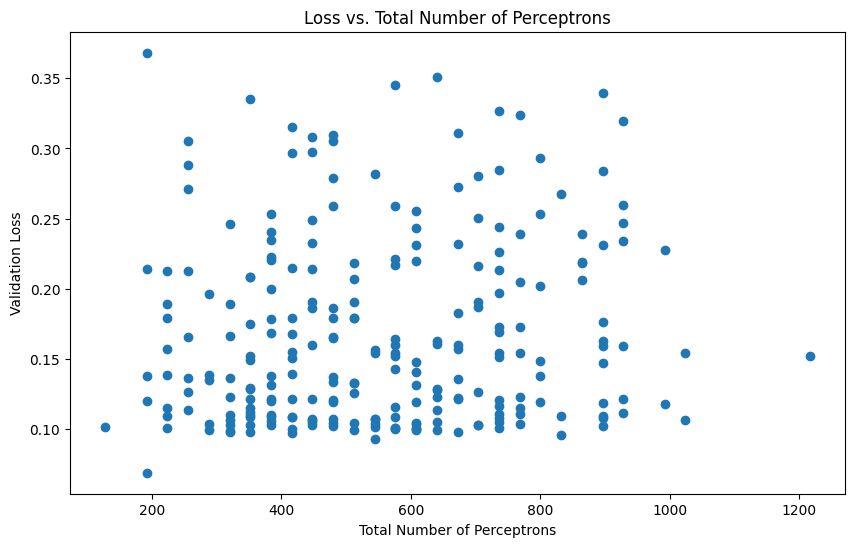

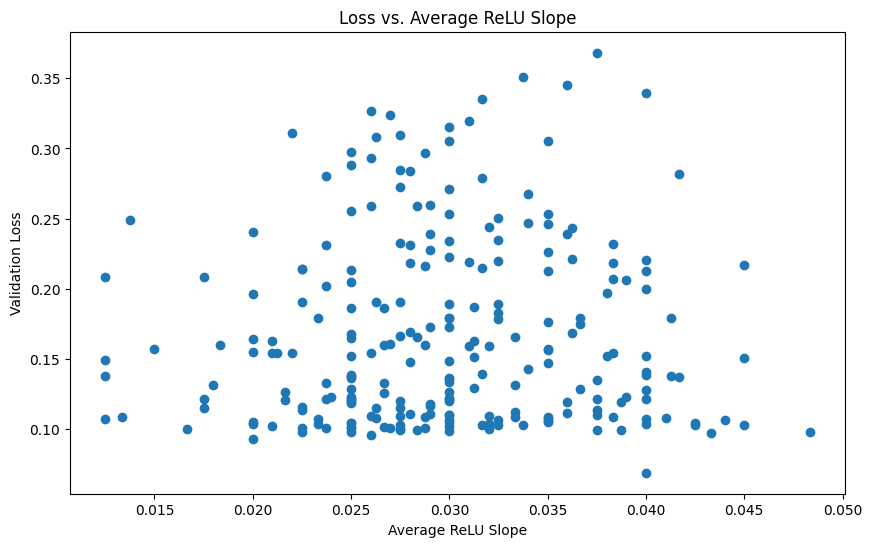

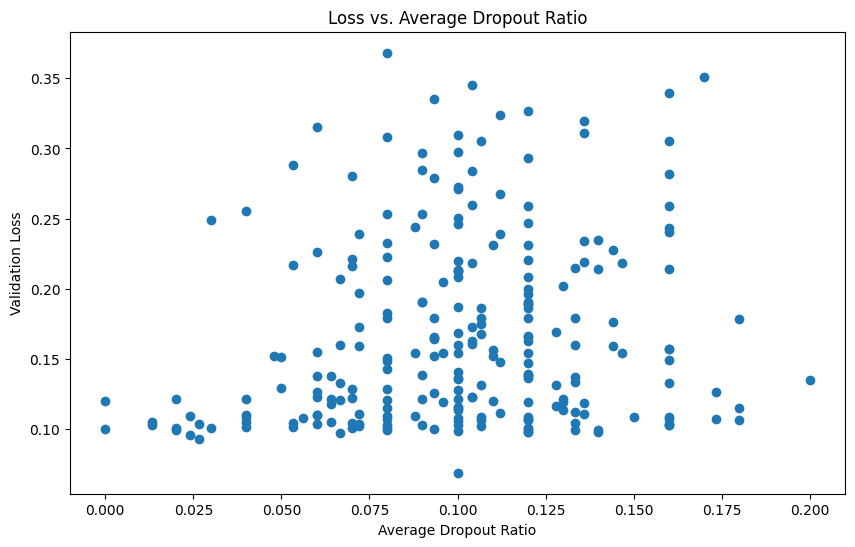

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the trials from the RandomSearch tuner
trials = tuner.oracle.get_best_trials(num_trials=tuner.oracle.max_trials)
# Initialize a list to store the trial data
trials_data = []
# Loop over each trial to extract the hyperparameters and performance metrics
for trial in trials:
    trial_dict = trial.hyperparameters.values
    trial_dict['val_loss'] = trial.score  
    trials_data.append(trial_dict)
# Convert the list of dictionaries to a DataFrame
random_search_results = pd.DataFrame(trials_data)

# Plot Loss vs. Total Number Perceptron
# Calculate the total number of perceptrons for each trial
random_search_results['total_perceptrons'] = random_search_results.apply(
    lambda row: sum([row[f'layer_{int(i)}_units'] for i in range(int(row['n_layers']))]), axis=1)
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(random_search_results['total_perceptrons'], random_search_results['val_loss'])
plt.title('Loss vs. Total Number of Perceptrons')
plt.xlabel('Total Number of Perceptrons')
plt.ylabel('Validation Loss')
plt.show()

# Plot Loss vs. Average ReLU Slope
# Calculate the average ReLU slope for each trial
random_search_results['average_relu_slope'] = random_search_results.apply(
    lambda row: np.mean([row[f'layer_{int(i)}_alpha'] for i in range(int(row['n_layers']))]), axis=1)
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(random_search_results['average_relu_slope'], random_search_results['val_loss'])
plt.title('Loss vs. Average ReLU Slope')
plt.xlabel('Average ReLU Slope')
plt.ylabel('Validation Loss')
plt.show()

# Plot Loss vs. Average Dropout Ratio
# Calculate the average dropout ratio for each trial
random_search_results['average_dropout_ratio'] = random_search_results.apply(
    lambda row: np.mean([row[f'layer_{int(i)}_dropout'] for i in range(int(row['n_layers']))]), axis=1)
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(random_search_results['average_dropout_ratio'], random_search_results['val_loss'])
plt.title('Loss vs. Average Dropout Ratio')
plt.xlabel('Average Dropout Ratio')
plt.ylabel('Validation Loss')
plt.show()

### #3.3 Fine Tuning using Bayesian Optimization
After using RandomSearch to broadly search through the large hyperparameter space, we will now use bayesian optimization to fine tune near the best found hyperparameter. Since keras_tuner doesn't allow initial point setting for bayesian optimization, we will restrict the hyperparameter space for bayesian optimization based on the best hyperparameter from RandomSearch. 

In [97]:
from keras_tuner.tuners import BayesianOptimization

# Based on the RandomSearch best hyperparameters, we build a new model with different range of hyperparameter
def build_bayesian_model(hp):
    model = Sequential()
    # Start around the best input units found by RandomSearch
    model.add(Dense(units=hp.Int('input_units', 
                                 min_value=max(32, best_hps.get('input_units') - 32), 
                                 max_value=best_hps.get('input_units') + 32, step=16), 
                                 input_shape=(sampled_design_matrix.shape[1],
                                              )))
    # Use the best input alpha found by RandomSearch as a reference
    model.add(LeakyReLU(alpha=hp.Float('input_alpha', 
                                        min_value=max(0.01, best_hps.get('input_alpha') - 0.01), 
                                        max_value=best_hps.get('input_alpha') + 0.01, 
                                        step=0.005)))
    # Use the number of layers found by RandomSearch as a starting point
    for i in range(best_hps.get('n_layers')):
        # Start around the best units found by RandomSearch for each layer
        model.add(Dense(units=hp.Int(f'layer_{i}_units', 
                                     min_value=max(32, best_hps.get(f'layer_{i}_units') - 32), 
                                     max_value=best_hps.get(f'layer_{i}_units') + 32, 
                                     step=16)))
        # Use the best alpha found by RandomSearch for each layer as a reference
        model.add(LeakyReLU(alpha=hp.Float(f'layer_{i}_alpha', 
                                            min_value=max(0.01, best_hps.get(f'layer_{i}_alpha') - 0.01), 
                                            max_value=best_hps.get(f'layer_{i}_alpha') + 0.01, 
                                            step=0.005)))
        # Start around the best dropout found by RandomSearch for each layer
        model.add(Dropout(hp.Float(f'layer_{i}_dropout', 
                                   min_value=max(0, best_hps.get(f'layer_{i}_dropout') - 0.1), 
                                   max_value=min(1, best_hps.get(f'layer_{i}_dropout') + 0.1), 
                                   step=0.05)))
    model.add(Dense(1))  # Output layer for regression
    # Use the best learning rate found by RandomSearch as a reference
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 
                 min_value=max(1e-6, best_hps.get('learning_rate') / 10), 
                 max_value=best_hps.get('learning_rate') * 10, 
                 sampling='log')),
                  loss='mean_squared_error')
    return model

bayesian_tuner = BayesianOptimization(
    build_bayesian_model,
    objective='val_loss',
    max_trials=45,
    executions_per_trial=2,
    directory='my_dir',
    project_name='material_optimization_bayesian'
)

bayesian_tuner.search(sampled_design_matrix, sampled_Y_train, epochs=10, validation_split=0.2)

# Get the best hyperparameters from Bayesian Optimization
best_hps_bayesian = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters from Bayesian Optimization
model = build_model(best_hps_bayesian)
model.fit(final_design_matrix, Y_train.reindex(final_design_matrix.index), epochs=50, validation_split=0.1)

Reloading Tuner from my_dir/material_optimization_bayesian/tuner0.json
Epoch 1/50
1975/1975 [==============================] - 2s 719us/step - loss: 0.1428 - val_loss: 0.0898
Epoch 2/50
1975/1975 [==============================] - 1s 693us/step - loss: 0.0754 - val_loss: 0.0843
Epoch 3/50
1975/1975 [==============================] - 1s 681us/step - loss: 0.0621 - val_loss: 0.0538
Epoch 4/50
1975/1975 [==============================] - 1s 703us/step - loss: 0.0533 - val_loss: 0.0528
Epoch 5/50
1975/1975 [==============================] - 1s 677us/step - loss: 0.0496 - val_loss: 0.0518
Epoch 6/50
1975/1975 [==============================] - 1s 679us/step - loss: 0.0450 - val_loss: 0.0501
Epoch 7/50
1975/1975 [==============================] - 1s 666us/step - loss: 0.0402 - val_loss: 0.0430
Epoch 8/50
1975/1975 [==============================] - 1s 687us/step - loss: 0.0379 - val_loss: 0.0450
Epoch 9/50
1975/1975 [==============================] - 1s 685us/step - loss: 0.0351 - val_loss: 

### #3.4 Interpretation of Input Importance for the Trainned DNN Model
Although interpretability of DNN is known to be lacking, we will use Gradient-based Feature Importance method in effort to see the "importance" of each input features. 

Top 5 Most Impactful Feature:
Feature 41 (LocalPropertyDifference_PCA_17): Importance = 0.11071322858333588
Feature 12 (MaximumPackingEfficiency): Importance = 0.121867835521698
Feature 19 (DensityFeatures_3): Importance = 0.13085997104644775
Feature 17 (DensityFeatures_1): Importance = 0.1412697732448578
Feature 18 (DensityFeatures_2): Importance = 0.32608523964881897


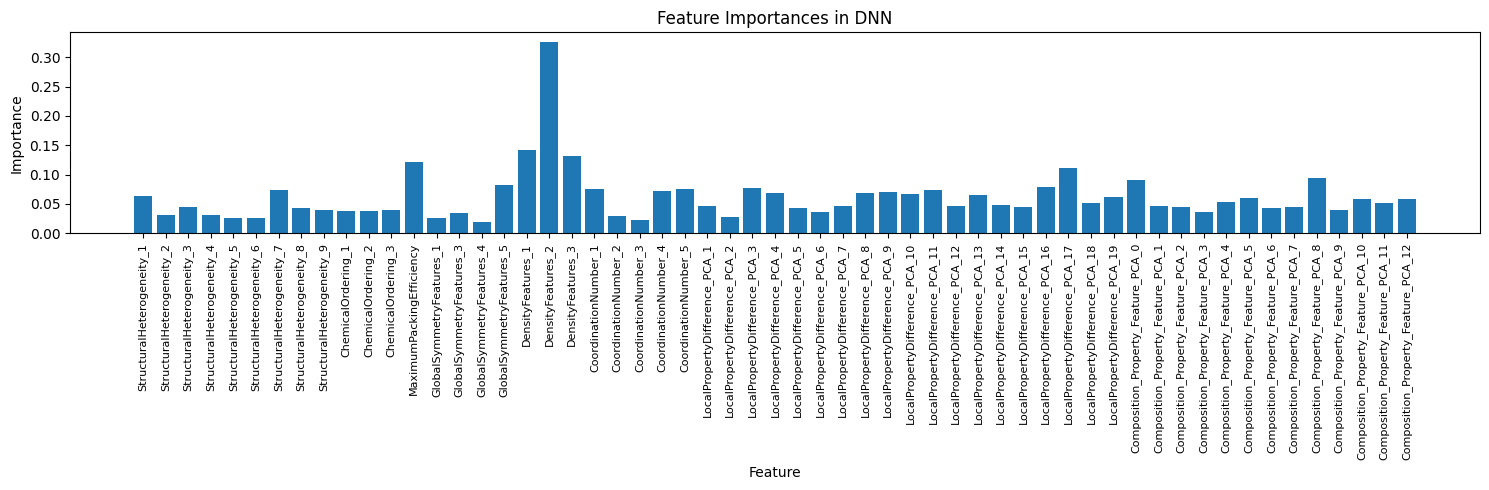

In [111]:
# Convert a batch of input data to a TensorFlow tensor
input_data_tensor = tf.convert_to_tensor(final_design_matrix, dtype=tf.float32)

# Use GradientTape to record the gradients
with tf.GradientTape() as tape:
    tape.watch(input_data_tensor)
    predictions = model(input_data_tensor)

# Compute the gradients of the output with respect to the input
gradients = tape.gradient(predictions, input_data_tensor)

# Reduce the gradients to a single value per feature (mean, max, or sum)
# Here we use the mean of the absolute gradients
feature_importances = np.mean(np.abs(gradients), axis=0)

# Sort the features by their importance and get the top 3
top_5_feature_indices = np.argsort(feature_importances,)[-5:]
top_5_feature_names = final_design_matrix.columns[top_5_feature_indices]

# Print the top 5 feature names and their importances
print('Top 5 Most Impactful Feature:')
for i in top_5_feature_indices:
    print(f"Feature {i} ({final_design_matrix.columns[i]}): Importance = {feature_importances[i]}")

# Plot the importance of each features
plt.figure(figsize=(15, 5)) 
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances in DNN')
plt.xticks(range(len(feature_importances)), final_design_matrix.columns, rotation=90, fontsize=8)
plt.tight_layout() 
plt.show()

From the above analysis, we found that three DensityFeatures, one MaximumPackingEfficiency feature, and one LocalProeprtyDifference feature were the most impactful features within the model, which can be physically interpreted:
- DensityFeatures: The formation energy is intrinsically linked to how densely atoms are packed, as this determines the strength of interatomic interactions. In the case of my DNN model, the high impact of DensityFeatures suggests that the model has learned to associate denser structures with potentially lower formation energies due to more energetically favorable, tightly-bound atomic arrangements. Given that high-density materials often result from strong covalent or ionic bonding, which is energetically favorable, it makes physical sense that these density features are significant predictors.
- MaximumPackingEfficiency: The high impact of packing feature on the prediction underscores the model's ability to capture the thermodynamic implications of atomic packing. A high packing efficiency usually indicates a stable crystalline structure with less space for atomic movement, implying lower formation energy. The model's sensitivity to MaximumPackingEfficiency reflects an understanding that materials with atoms arranged in a highly efficient manner are likely to be more stable, and hence have lower formation energies. 
- LocalPropertyDifference: The significance of this feature in my model's predictions can be rationalized by considering the role of local atomic environments in determining a material's stability. Although PCA was applied-which reduced and mashed the dimensions of many LocalPropertyDifference features- for sake of trainning efficency, this feature still inherently captures the local differentials in atomic environments. And since variations in properties like electronegativity and atomic size at the local level can lead to different types of chemical bonds, affecting the overall energy of the syste, the model's reliance on LocalPropertyDifference indicates it has learned that heterogeneity in the local atomic environment can stabilize or destabilize a material, thus affecting its formation energy. In other words, the model recognizes that the interplay of local atomic interactions can be indicative of the energy required to form a material, with certain local property differences being characteristic of either high or low formation energies.

### #3.5 Random Forrest model

#### #3.5.1 Optimize and Train Random Forrest model
##### We will also make Random Forrest model as well to compare the DNN's performance

Text(0, 0.5, '-MSE')

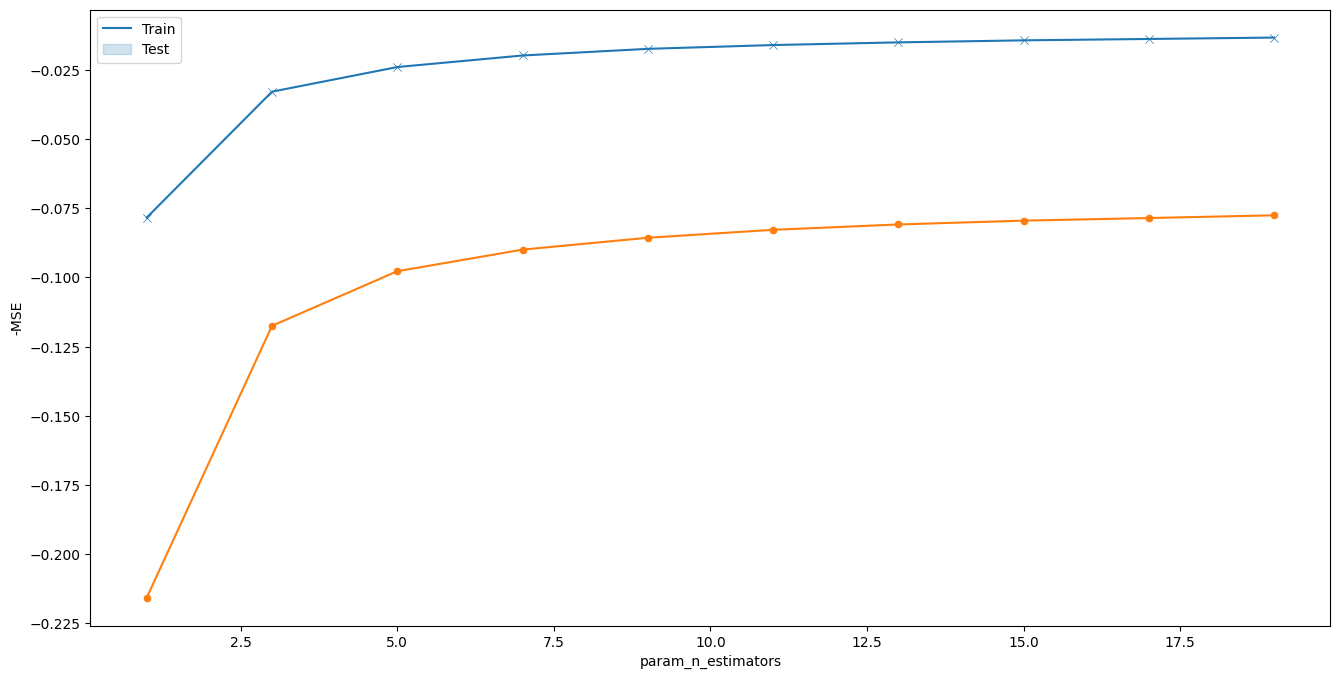

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
def plot_grid_search_results(gs, ylim=None):
    """
    Plots the results of GridSearchCV.

    Args:
        gs: A GridSearchCV object.
        ylim: Optional setting for y limits.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(x=x, y="mean_train_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_train_score", data=results, marker="x")
    ax = sns.lineplot(x=x, y="mean_test_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_test_score", data=results, marker="o")
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    ax.legend(["Train", "Test"], loc=2)

# Find appropriate n_estimators
rf_model = RandomForestRegressor(random_state=0)

# Perform gridsearch for n_estimator
gs = GridSearchCV(
    rf_model,
    param_grid={"n_estimators": range(1, 20, 2)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=8,
)
gs.fit(final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'])
plot_grid_search_results(gs)
plt.ylabel("-MSE")

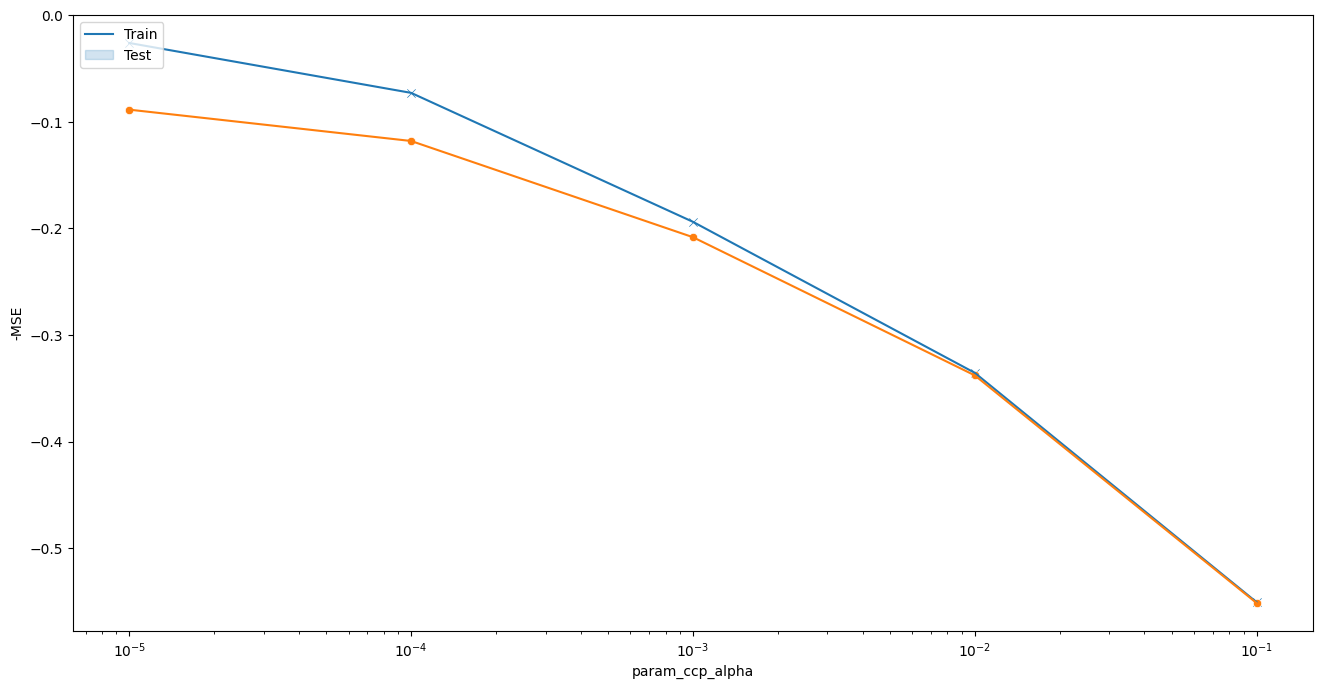

In [63]:
# Find appropriate ccp_alpha
rf_model = RandomForestRegressor(random_state=0, n_estimators=11)
# Perform gridsearch for appropriate ccp_alpha
gs = GridSearchCV(
    rf_model,
    param_grid={"ccp_alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=8,
)
gs.fit(final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'])
plot_grid_search_results(gs)
plt.ylabel("-MSE")
plt.xscale("log")

In [64]:
# Based on the Hyperparameter graph, we tune it to ~5e-3 where accuracy is still in -0.1~-0.2 region, but it is not overfitted.
rf_model = RandomForestRegressor(random_state=0, n_estimators=10, ccp_alpha=5e-3)
rf_model.fit(final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'])

RandomForestRegressor(ccp_alpha=0.005, n_estimators=10, random_state=0)

#### #3.5.2 Interpret Fully Trained Random Forest Model

Top 3 Most Impactful Features:
StructuralHeterogeneity_7        0.325967
LocalPropertyDifference_PCA_3    0.146892
LocalPropertyDifference_PCA_7    0.101200
dtype: float64


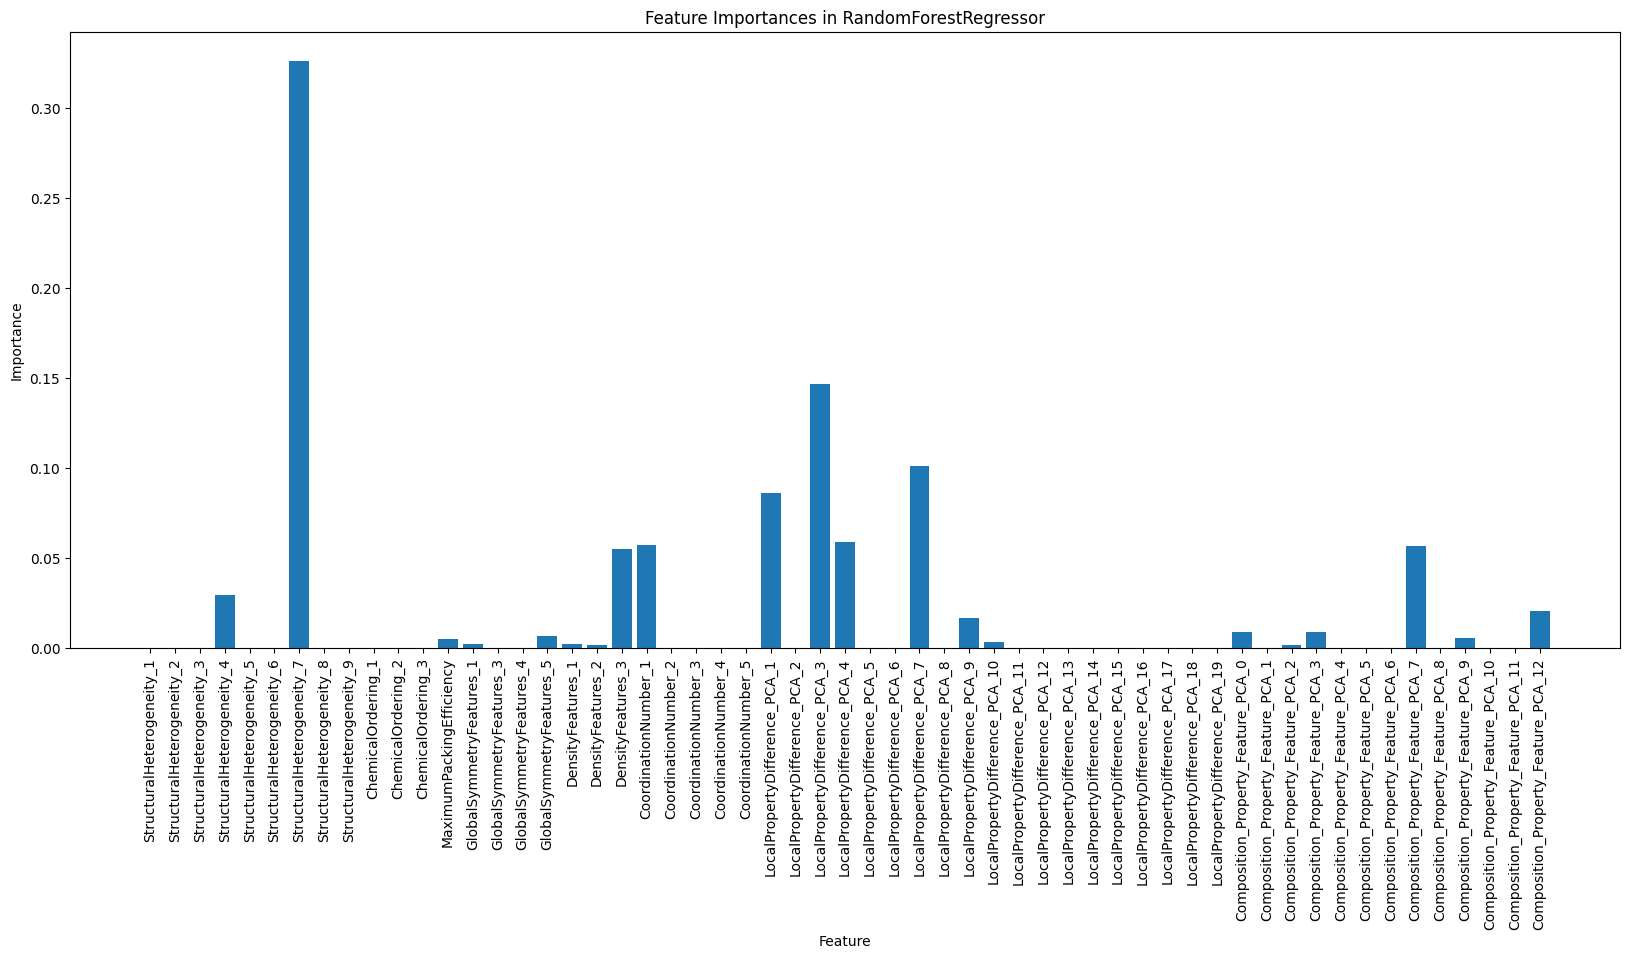

In [112]:
feature_importances = rf_model.feature_importances_
features = np.array(final_design_matrix.columns)  # Replace 'feature_names' with your actual feature names

# Create a pandas series to combine the importances and feature names, then sort them
importances_series = pd.Series(feature_importances, index=features)
print('Top 3 Most Impactful Features:')
print(importances_series.sort_values(ascending=False).head(3))
# Plotting
plt.figure(figsize=(20, 8))  # Adjust the size of the figure as needed
plt.title('Feature Importances in RandomForestRegressor')
plt.bar(importances_series.index, importances_series.values)
plt.xticks(rotation='vertical')  # Rotate feature names for better readability
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

From the above analysis, we found that  StructuralHeterogeneity, two LocalProeprtyDifference feature were the most impactful features within the model, which can be physically interpreted:
- StructuralHeterogeneity: As we have discussed within Section #2(featurization), this featurizer measures the variability in bond lengths and atomic volumes of the material. Since such bond/volume variability is interconnected with stability and energy of a compound, it makes sense that one of the features from StructuralGeterogeneity plays an important role in formation energy prediction. 
- LocalPropertyDifference: Identical to the reasoning in the DNN interpretation part, the significance of this feature in my model's predictions can be rationalized by considering the role of local atomic environments in determining a material's stability. Although PCA was applied-which reduced and mashed the dimensions of many LocalPropertyDifference features- for sake of trainning efficency, this feature still inherently captures the local differentials in atomic environments. And since variations in properties like electronegativity and atomic size at the local level can lead to different types of chemical bonds, affecting the overall energy of the system, the model's reliance on LocalPropertyDifference indicates it has learned that heterogeneity in the local atomic environment can stabilize or destabilize a material, thus affecting its formation energy.

### #3.6 Linear Ridge, Lasso model

#### #3.6.1 Linear Ridge, Lasso model Training/Optimiazation
The alpha values were optimized by tweaking the alpha ranges bit by bit, until approaching convergence within the provided domain in the alphas variable

In [125]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set up for finding best alpha
alphas = (np.linspace(17.772, 17.776, num=10), np.linspace(1.1e-5, 1.12e-5, num=10)) # alphas[0] for Ridge model alphas, alphas[1] for Lasso model alphas
model = (Ridge, Lasso)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
best_alpha = [0,0] # will store the best alphas
model_name = ('Ridge', 'Lasso')

for i in range(2):
    # List to hold (alpha, error) pair
    cv_results = []
    # Find best alpha within the range
    for alpha in alphas[i]:
        reg_model = model[i](alpha=alpha, max_iter=100000)
        scores = cross_validate(reg_model, final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'], cv=kfold, scoring="neg_mean_squared_error", n_jobs=-1)
        # Append the (alpha, error) pair
        cv_results.append((alpha, -np.mean(scores["test_score"])))
    # Find the best alpha with lowest MSE
    cv_results = pd.DataFrame(cv_results, columns=["alpha", "score"])
    best_alpha[i] = cv_results["alpha"][cv_results["score"].idxmin()]
    # Find CV result of the model using best alpha
    reg_model = model[i](alpha=best_alpha[i], max_iter=100000)
    yhat_reg_model = cross_val_predict(reg_model, final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'], cv=kfold)
    r2_reg_model = r2_score(Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'], yhat_reg_model)
    mse_reg_model = mean_squared_error(Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'], yhat_reg_model)
    rmse_reg_model = np.sqrt(mse_reg_model)
    mae_reg_model = mean_absolute_error(Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'], yhat_reg_model)
    print(f"Best alpha for {model_name[i]} model: {best_alpha[i]}")
    print(f'Cross Validation Score of {model_name[i]} Regressgion Model w/ α={best_alpha[i]:.6f}:\n   - MSE: {mse_reg_model:.6f}\n   - RMSE: {rmse_reg_model:.6f}\n   - MAE: {mae_reg_model:.6f}\n   - R^2: {r2_reg_model:.6f}\n')

# Make final ridge and lasso models for later use
ridge_model = model[0](alpha=best_alpha[0], max_iter=100000).fit(final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'])
lasso_model = model[1](alpha=best_alpha[1], max_iter=100000).fit(final_design_matrix, Y_train.reindex(final_design_matrix.index)['formation_energy_per_atom'])

Best alpha for Ridge model: 17.77422222222222
Cross Validation Score of Ridge Regressgion Model w/ α=17.774222:
   - MSE: 0.210055
   - RMSE: 0.458318
   - MAE: 0.315946
   - R^2: 0.682278

Best alpha for Lasso model: 1.1155555555555555e-05
Cross Validation Score of Lasso Regressgion Model w/ α=0.000011:
   - MSE: 0.210056
   - RMSE: 0.458318
   - MAE: 0.315925
   - R^2: 0.682278



#### #3.6.2 Linear Ridge, Lasso model Interpretation


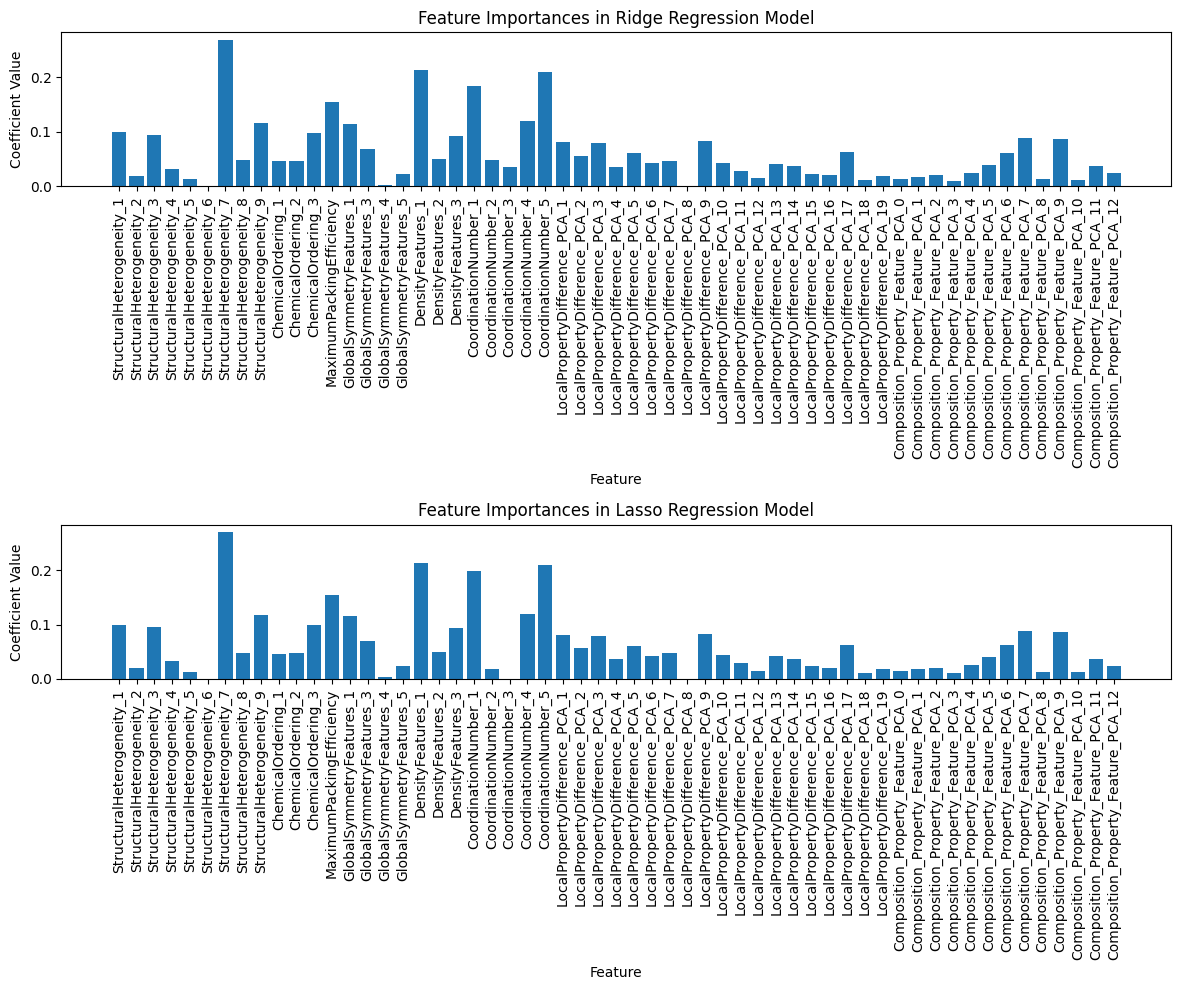

In [127]:
feature_names = final_design_matrix.columns

# Get the coefficients from the models
ridge_coefficients = abs(ridge_model.coef_)
lasso_coefficients = abs(lasso_model.coef_)

# Create subplots for both models
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Ridge coefficients
axs[0].bar(feature_names, ridge_coefficients)
axs[0].set_title('Feature Importances in Ridge Regression Model')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('Absolute Coefficient Value')
axs[0].tick_params(axis='x', rotation=90)

# Lasso coefficients
axs[1].bar(feature_names, lasso_coefficients)
axs[1].set_title('Feature Importances in Lasso Regression Model')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Absolute Coefficient Value')
axs[1].tick_params(axis='x', rotation=90)

# Adjust the layout
plt.tight_layout()
plt.show()

From the above analysis, we found that  StructuralHeterogeneity, DensityFeatures, and CoordinationNumber were the most impactful features within the model, which can be physically interpreted:
- StructuralHeterogeneity: As we have discussed within Section #2(featurization), this featurizer measures the variability in bond lengths and atomic volumes of the material. Since such bond/volume variability is interconnected with stability and energy of a compound, it makes sense that one of the features from StructuralGeterogeneity plays an important role in formation energy prediction. 
- DensityFeatures: We also have discussed the importance of Density Features when dealing with DNN interpretation, please refer to section #3.4.
- CoordinationNumber: In section #2, I have stated that: Since the coordination number reflects the geometric arrangement and density of packing around an atom, I believe that the compound's stability and energy,and hence formation energy, will be closely related. It makes sense to see the linear regression using such broad term as a one of the most impactful predictors.

## #4 Model Testing

### #4.1 Test Data Setup
First get the test dataset, and make it into format that is capable of being inputted into the trainned model. We will be using almost identical steps as we did to format the training data.

In [90]:
test_data_raw = pd.read_csv('data/test_oxides.csv')
# Acquire Material Project API with MPRester for required fields
with MPRester("vTVq5BnCcZkrMtsqdQG24AEZJIIxnXa9") as mpr:
    test_docs = mpr.materials.summary.search(
        material_ids=list(test_data_raw["material_id"])
    )
# Make it into Pandas data frame
raw_test_tmp = []
for doc in test_docs:
    doc_data = {}
    for feature, value in doc:
        doc_data[feature] = value
    raw_test_tmp.append(doc_data)
# Convert the list of dictionaries into a DataFrame
raw_test_df = pd.DataFrame(raw_test_tmp)
# Set index of the training data for easier visualization
raw_test_df.set_index('material_id', inplace=True)

Retrieving SummaryDoc documents:   0%|          | 0/2970 [00:00<?, ?it/s]

##### There are missing material information from Materials Project for 30 materials. I tried to identify those missing material, make very random initial structure and use MatGL M3GNet to relax the structure to get the structural information for those. I wanted to initially find similar structure on Mateirals Project and perform substitution, however, due to the recent change in MP API query system, I was not able to query using specific requirements other than the materials_id. 
##### HOWEVER, M3GNet Relaxation took too long for my local computer, and hence, it was later decided that the average value of formation energy value will be used for the structures that were not available in MP API.

In [24]:
# Previous Code that was made to "estimate" the structures based on their Formula for the material that were not in MP API
'''
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import matgl
from matgl.ext.ase import Relaxer

# Identify the missing materials from MP API
missing_mat_id = list(set(test_data_raw['material_id']) - set(raw_test_df.index))
# Get their chemical formula
chemical_formulae = [test_data_raw[test_data_raw['material_id'] == mat_id]['formula_pretty'].iloc[0] for mat_id in missing_mat_id]

# Using chemical formulae, make very simple initial structures
# Placeholder for initial structures
initial_structures = []
for formula in chemical_formulae:
    comp = Composition(formula)
    lattice = Lattice.cubic(10.0)
    # Generating species and amounts based on the composition
    species = []
    coords = []
    for element, amount in comp.get_el_amt_dict().items():
        species.extend([str(element)] * int(amount))
        # Distribute these atoms evenly in the unit cell
        new_coords = np.linspace(0, 1, int(amount), endpoint=False)
        coords.extend([[x, x, x] for x in new_coords])
    structure = Structure(lattice, species, coords, coords_are_cartesian=False)
    initial_structures.append(SpacegroupAnalyzer(structure).get_conventional_standard_structure())
# Load M3GNet Potential
pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
# Initialize a relaxer using M3GNet Pot
relaxer = Relaxer(potential=pot)
# Initialize a relaxed structure
relaxed_structures = []
for initial_struct in initial_structure:
    relax_results = relaxer.relax(struct, fmax=0.01)
    relaxed_structures.append(relax_results["final_structure"])

# Make new pandas dataframe using the new data
new_data = {
    'material_id': list(missing_mat_id), 
    'formula_pretty': chemical_formulae, 
    'structure': relaxed_structures,
    'composition': [Composition(x) for x in chemical_formulae]
}
# Create a new DataFrame from the new data
new_df = pd.DataFrame(new_data)
# Set 'material_id' as the index
new_df.set_index('material_id', inplace=True)
# Concatenate with the existing DataFrame
raw_test_df = pd.concat([raw_test_df, new_df])
'''

In [91]:
# Featurize and index the data(This was also only used once, then the result was saved to local and loaded)
# Hence **************Please ignore the output*************
structural_test_matrix = pd.DataFrame(featurizer.featurize_many(raw_test_df['structure'], ignore_errors=True))
structural_test_matrix.columns = column_names
structural_test_matrix.index = raw_test_df.index

MultipleFeaturizer:   0%|          | 0/2970 [00:00<?, ?it/s]

KeyboardInterrupt: 

##### In training step, we ignored all the rows with NaN values since they only accounted for around ~1% of the total training data, and hence would not greatly impact training of the models. However, for testing purpose, we need to generate formation energy predictions for all of the inputed materials. As a result, for the test set materials that results in NaN for structural features, we will use the formation energy from the MP API, since the number of total NaN rows very miniscule, and we cannot properly judge the model accuracy if these NaN values too drastically deviates the error.
##### The following NaN rows are the result of incompleteness of relaxation for some materials in MP API.

In [101]:
# First take out the column that describes the spacegroup of the material in String
structural_test_matrix = structural_test_matrix.drop('GlobalSymmetryFeatures_2', axis=1)
# Count the rows where the NaN is located
rows_with_nan = structural_test_matrix[structural_test_matrix.isna().any(axis=1)]
print(f'Number of rows with NaN in structural design matrix : {len(rows_with_nan)}')
# Get indices of rows with NaN
nan_indices = rows_with_nan.index
structural_test_matrix_filled = structural_test_matrix.drop(nan_indices)
print(structural_test_matrix_filled.shape)

Number of rows with NaN in structural design matrix : 77
(2893, 135)


In [102]:
# The PCA is identically applied as it was to the training set. Refer back to Section #2.2.2 for more detail.
scaler = StandardScaler()
scaled_data_test = scaler.fit_transform(structural_test_matrix_filled)
# Apply PCA to the last 110 columns of the standardized data, keeping only 19 components to match the training set input
pca = PCA(n_components=19)
X_pca = pca.fit_transform(scaled_data_test[:, -110:])
# Combine the first 25 columns (scaled) with the 19 PCA components
final_data = np.concatenate((scaled_data_test[:, :25], X_pca), axis=1)
# Create the DataFrame
structural_test_matrix_filled_pca = pd.DataFrame(final_data)
structural_test_matrix_filled_pca.index = structural_test_matrix_filled.index
structural_test_matrix_filled_pca.columns = list(structural_test_matrix_filled.columns[:25]) + [f'LocalPropertyDifference_PCA_{n}' for n in range(1,20)]
print(f'Dimension of Structural Feature Matrix for Test set: {structural_test_matrix_filled_pca.shape}')

Dimension of Structural Feature Matrix for Test set: (2893, 44)


In [103]:
# Get the compositional features; the steps and helper functions are identical to section #2.1 
prop_df_test = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
# Get max, min, and avg of compositional properties of each compound
for i in range(3):
    for property in element_df.columns:
        # Make dictionary for faster access to the property of interest
        element_dict = element_df[property].to_dict()
        # Calculate the composition-averaged property for all materials that we got structural features for
        result = raw_test_df.loc[~raw_test_df.index.isin(nan_indices)]['composition'].apply(composition_operators[i])
        prop_df_test[i].loc[:, property + name[i]]  = result
composition_test_matrix = pd.concat([prop_df_test[2], prop_df_test[0], prop_df_test[1]], axis=1)

# Standardizing the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(composition_test_matrix)
# Applying PCA
pca = PCA(n_components=num_components_PCA_composition)
composition_test_matrix_pca = pca_filtered.fit_transform(df_scaled)
# Massage the data into pd.DataFrame with appropriate index
composition_test_matrix_pca = pd.DataFrame(composition_test_matrix_pca)
composition_test_matrix_pca.index = raw_test_df.loc[~raw_test_df.index.isin(nan_indices)].index
composition_test_matrix_pca.columns = [f'Composition_Property_Feature_PCA_{n}' for n in range(13)]
print(f'Dimension of Compositional Feature Matrix for Test set: {composition_test_matrix_pca.shape}')

Dimension of Compositional Feature Matrix for Test set: (2893, 13)


In [104]:
# Final Design Matrix of training Input Data
final_test_matrix = pd.concat([structural_test_matrix_filled_pca, composition_test_matrix_pca], axis=1)
print(f'Dimension of Final Input Test Data: {final_test_matrix.shape}')

Dimension of Final Input Test Data: (2893, 57)


### #4.2 Making Predictions
#### #4.2.1 DNN Predictions

In [107]:
# Use the previously fully trainned DNN to make predictions
dnn_predictions = model.predict(final_test_matrix)
# Convert it into Pandas Dataframe
dnn_predictions_df = pd.DataFrame(dnn_predictions, index=final_test_matrix.index, columns=['formation_energy_per_atom'])
dnn_predictions_df.index.name = 'material_id'
print(f'Predictions dimension: {dnn_predictions_df.shape}')
# Fill in the materials with formation energy for those that the structural featurizer coudln't featurize
df = raw_test_df.loc[[x for x in nan_indices]][['formation_energy_per_atom']]
dnn_predictions_df= dnn_predictions_df.append(df)
# Fill in the materials missing in Material Project API with average value, from training set since there are more 
# Identify the missing materials from MP API
missing_mat_id = list(set(test_data_raw['material_id']) - set(raw_test_df.index))
# Calculate the average formation energy from training set
avg_formation = train_data_raw['formation_energy_per_atom'].mean()
# Make new dataframe accordingly
new_data = pd.DataFrame({'formation_energy_per_atom': [avg_formation] * len(missing_mat_id)}, 
                        index=missing_mat_id)
dnn_predictions_df = dnn_predictions_df.append(new_data)
print(f'Final Predictions dimension: {dnn_predictions_df.shape}')
dnn_predictions_df.head()
dnn_predictions_df.index.name = 'material_id'
# Save to csv
dnn_predictions_df.to_csv('DNN_prediction.csv')

91/91 [==============================] - 0s 363us/step
Predictions dimension: (2893, 1)
Final Predictions dimension: (3000, 1)


/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/359962069.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dnn_predictions_df= dnn_predictions_df.append(df)
/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/359962069.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dnn_predictions_df = dnn_predictions_df.append(new_data)


#### #4.2.2 Random Forest Predictions

In [106]:
# Use the previously fully trainned Random Forest Regressor to make predictions
rf_predictions = rf_model.predict(final_test_matrix)
# Convert it into Pandas Dataframe
rf_predictions_df = pd.DataFrame(rf_predictions, index=final_test_matrix.index, columns=['formation_energy_per_atom'])
rf_predictions_df.index.name = 'material_id'
print(f'Predictions dimension: {rf_predictions_df.shape}')
# Append the rest of the data
rf_predictions_df = rf_predictions_df.append(df)
rf_predictions_df = rf_predictions_df.append(new_data)
rf_predictions_df.index.name = 'material_id'
print(f'Final Predictions dimension: {rf_predictions_df.shape}')
rf_predictions_df.to_csv('RF_prediction.csv')

Predictions dimension: (2893, 1)
Final Predictions dimension: (3000, 1)


/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/353430059.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_predictions_df = rf_predictions_df.append(df)
/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/353430059.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_predictions_df = rf_predictions_df.append(new_data)


#### #4.2.3 Ridge/Lasso Regression Predictions

In [128]:
# Use the previously fully trainned Ridge/Lasso model to make predictions
ridge_predictions = ridge_model.predict(final_test_matrix)
lasso_predictions = lasso_model.predict(final_test_matrix)
# Convert it into Pandas Dataframe
ridge_predictions_df = pd.DataFrame(ridge_predictions, index=final_test_matrix.index, columns=['formation_energy_per_atom'])
lasso_predictions_df = pd.DataFrame(lasso_predictions, index=final_test_matrix.index, columns=['formation_energy_per_atom'])
ridge_predictions_df.index.name = 'material_id'
lasso_predictions_df.index.name = 'material_id'
# Append the rest of the data
ridge_predictions_df = ridge_predictions_df.append(df)
ridge_predictions_df = ridge_predictions_df.append(new_data)
lasso_predictions_df = lasso_predictions_df.append(df)
lasso_predictions_df = lasso_predictions_df.append(new_data)
ridge_predictions_df.index.name = 'material_id'
lasso_predictions_df.index.name = 'material_id'
print(f'Final Predictions dimension: {ridge_predictions_df.shape} & {lasso_predictions_df.shape}')
ridge_predictions_df.to_csv('Ridge_prediction.csv')
lasso_predictions_df.to_csv('Lasso_prediction.csv')

Final Predictions dimension: (3000, 1) & (3000, 1)


/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/3441964556.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ridge_predictions_df = ridge_predictions_df.append(df)
/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/3441964556.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ridge_predictions_df = ridge_predictions_df.append(new_data)
/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/3441964556.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lasso_predictions_df = lasso_predictions_df.append(df)
/var/folders/gh/zvwm9c4560b6m7w4r02b22500000gn/T/ipykernel_90221/3441964556.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu